In [1]:
import utils
from utils import *

In [2]:
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\lucas\\DataScience\\l3stockmdl\\utils.py'>

In [3]:
#df, meta_data = get_data('PETR4.SA.SAO')
#print(meta_data)

df = pd.read_csv('./databases/PETR4_2024-08-19.csv')

In [4]:
df = stock_feature_prep(df)

In [5]:
lgbm, best_params, best_score, y_pred, y_test = modeling(df)

In [6]:
df['predicted'] = lgbm.predict(df[lgbm.feature_name_])

In [7]:
df[['date', 'close', 'open', 'open_lag_1', 'close_lag_1', 'predicted', 'target']].sort_values(by='date', ascending=False).head(10)

,date,close,open,open_lag_1,close_lag_1,predicted,target
0,2024-08-16,38.50,38.17,38.05,38.34,32.118978,NaN
1,2024-08-15,38.34,38.05,37.19,37.76,33.251233,38.50
2,2024-08-14,37.76,37.19,37.53,37.11,34.197779,38.34
3,2024-08-13,37.11,37.53,36.80,37.34,35.604708,37.76
4,2024-08-12,37.34,36.80,36.13,36.51,36.139415,37.11
5,2024-08-09,36.51,36.13,36.35,36.85,35.212442,37.34
6,2024-08-08,36.85,36.35,36.70,36.27,35.427506,36.51
7,2024-08-07,36.27,36.70,35.60,36.32,35.567508,36.85
8,2024-08-06,36.32,35.60,34.80,35.70,35.342778,36.27
9,2024-08-05,35.70,34.80,36.72,35.73,35.067572,36.32


In [8]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

r2, rmse

(0.9383702229808669, 1.387199970773927)

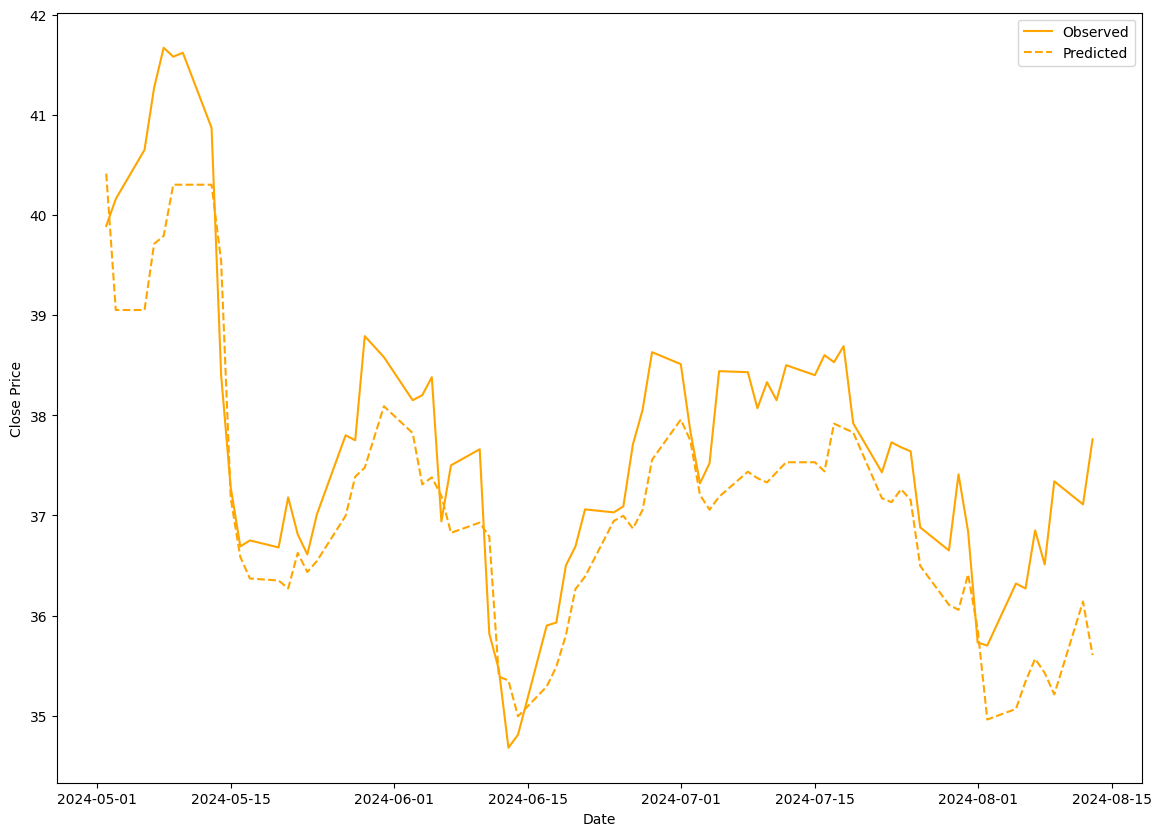

In [10]:
df.sort_values('date', inplace=True)
temp = df[df['date'] > '2024-05-01']
temp = temp[temp['date'] < '2024-08-14']

# Plot stock close price per day
# Set the figure size - 10x6 inches
plt.figure(figsize=(14, 10))
plt.plot(temp['date'], temp['target'], color='orange', label='Observed')
plt.plot(temp['date'], temp['predicted'], color='orange', linestyle='--', label='Predicted')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Show the plot
plt.show()

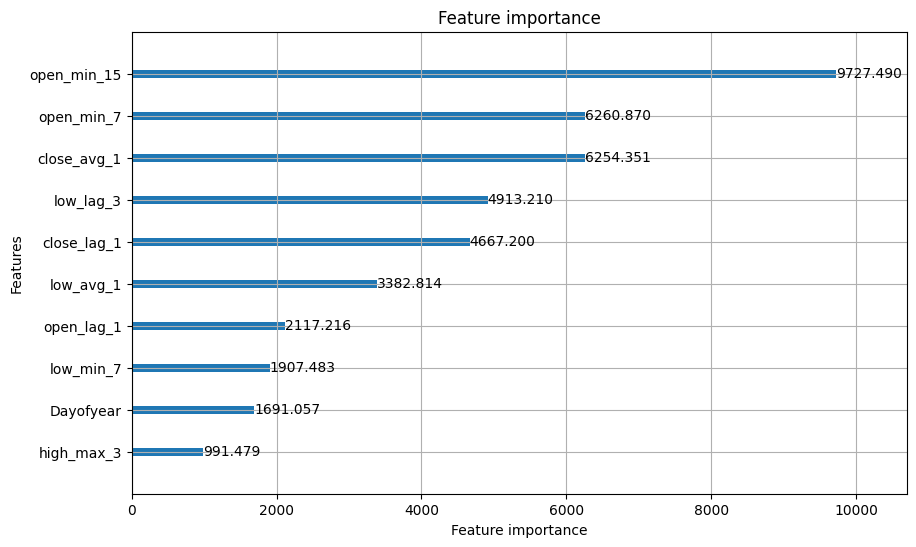

In [11]:
# Assuming you have a trained LightGBM model named 'lgbm'
lgb.plot_importance(lgbm, importance_type='gain', figsize=(10, 6), max_num_features=10)
plt.show()